## RAGAS 기본 데이터의 한계와 Custom 데이터의 필요성
1. Custom Dataset의 특징 및 구성
    - 사용자 페르소나와 핵심 키워드를 기반으로 실제 사용자 질의와 유사한 형태의 데이터셋을 구축
    - 실제 사용자 시나리오를 반영한 평가 데이터셋으로 구성

2. First-Stage Retrieve 단계에서의 실험 결과
    - Custom Dataset과 RAGAS 합성 데이터셋을 비교 실험 수행
    - Custom Dataset이 RAGAS 합성 데이터셋 대비 더 도전적인 평가 문제를 제시함을 통계적으로 확인
    - 상위 10% 결과 비교 분석 결과, 두 데이터셋 간 공통 포함 비율이 14%에 불과
    - 이는 두 데이터셋이 서로 다른 랭킹 기준을 가지고 있음을 시사

3. 결론
    - Custom Dataset과 RAGAS 합성 데이터셋의 조합이 First-Stage Retrieve 단계의 평가에 필수적
    - Custom Dataset은 실제 사용자 시나리오를 반영한 현실적인 평가 기준을 제공
    - RAGAS 합성 데이터셋은 일반적인 케이스에 대한 평가 기준을 제공
    - 두 데이터셋의 조합을 통해 더 포괄적이고 견고한 평가 체계 구축 가능

## RAGAS Customization 필요성 확인 절차
1. ragas 기반의 기본 합성 데이터셋 생성
2. custom 데이터셋 생성
3. 기본 합성 데이터셋 기반 검색 절차의 optimization 진행
4. custom 데이터셋 기반 검색 절차의 optimization 진행
5. 평가지표 비교를 통한 필요성 확인
   * 통계적 유의성 테스트
   * 정렬 결과 차이 분석(Rank Sensitivity)

In [1]:
import os
import re
import pandas as pd
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

from dotenv import load_dotenv
load_dotenv()

True

In [2]:
origin_path = '../data/document/역도/generated_persona_dataset.csv'
origin_dataset = pd.read_csv(origin_path)

custom_path = '../data/document/역도/customDataset.csv'
custom_dataset = pd.read_csv(custom_path)

origin_dataset['reference_contexts'] = origin_dataset['reference_contexts'].apply(lambda x : [re.sub(r"<\d+-hop>\n\n", "", text) for text in eval(x)])
custom_dataset['reference_contexts'] = custom_dataset['reference_contexts'].apply(lambda x : [re.sub(r"<\d+-hop>\n\n", "", text) for text in eval(x)])

In [3]:
origin_dataset.head(2)

,user_input,reference_contexts,reference,synthesizer_name,precompute_dense,precompute_sparse_bm25,precompute_sparse_bm25_kiwi,precompute_sparse_bm25_kiwi_pos
0,역도 대회에서 엄지(thumb) 사용에 관한 규정은 무엇인가요?,"[3) 벨트의 최대 넓이는 12cm를 넘지 말아야 한다. 4) 붕대, 반창고 혹은 ...",역도 대회에서 붕대(bandage) 혹은 석고(cast)는 손가락(finger) 혹...,single_hop_specifc_query_synthesizer,[(Document(id='fb398d48-340c-4b83-bf2f-f547942...,"['주니어는 총 8체급으로 구성되어 있으며, 체급은 56kg 이하부터 시작하여 10...",['평소 건강했던 선수도 갑자기 신체의 조정 기구에 이상이 있으면 피부색이나 얼\n...,"['주니어는 총 8체급으로 구성되어 있으며, 체급은 56kg 이하부터 시작하여 10..."
1,바벨의 무게를 들어올리기 위해 필요한 회전력은 얼마인가요?,"[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s...",바벨이 150kg이고 바벨의 수직축과 엉덩이 관절까지의 거리가 60cm라면 바벨을 ...,single_hop_specifc_query_synthesizer,[(Document(id='4d9ba556-4c0d-4281-a99c-3cdbcaf...,['또한 이때 사용되는 지레는 어\n깨관절을 회전축으로 한 지레인데 바벨의\n저항팔...,['평소 건강했던 선수도 갑자기 신체의 조정 기구에 이상이 있으면 피부색이나 얼\n...,"['인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, ..."


In [4]:
import json
from langchain_core.documents import Document

with open('../data/document/역도/chunk_with_overlap.json', 'r') as f:
    chunks_origin = json.load(f)

chunks_origin = sum(chunks_origin, [])

with open('../data/document/역도/table_chunk.json', 'r') as f:
    table_origin = json.load(f)

documents = [Document(page_content=chunk['page_content'],
                      metadata=chunk['metadata'])
                       for chunk in chunks_origin]

# Retrieve(First-Stage Retrieval) 최적화

### Dense Retriever 선언

In [10]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()
db = FAISS.from_documents(documents, embeddings)
# dense_retriever = db.as_retriever()

### Sparse Retriever 선언

In [11]:
from kiwipiepy import Kiwi
from typing import List, Dict, Any
from rank_bm25 import BM25Okapi

class BM25:
    def __init__(self, type: str = 'None', k: int = 15):
        self.k = k
        self.type = type
        self.kiwi = Kiwi()
        self.texts = []
        self.vectorizer = None

    
    def tokenize(self, text: str) -> List[str]:
        if self.type == 'None':
            return text.split()
        elif self.type == 'kiwi':
            return [token.form for token in self.kiwi.tokenize(text)]
        elif self.type == 'kiwi_pos':
            return [token.form for token in self.kiwi.tokenize(text) if token.tag.startswith(('NN', 'VV', 'VA'))]
        else:
            raise ValueError(f"지원하지 않는 토크나이저 타입입니다: {self.type}. 'None', 'kiwi', 'kiwi_pos' 중 하나를 선택해주세요.")
        

    def from_texts(self, texts: List[str]):
        self.texts = texts
        texts_processed = [self.tokenize(t) for t in texts]
        self.vectorizer = BM25Okapi(texts_processed)
    
    def search(self, query: str) -> List[str]:
        if not self.vectorizer:
            raise ValueError("BM25가 초기화되지 않았습니다. from_texts()를 먼저 호출하세요.")
        
        processed_query = self.tokenize(query)
        
        return self.vectorizer.get_top_n(processed_query, self.texts, n=self.k)

In [12]:
kiwi_pos = BM25(k=15, type='kiwi_pos')
kiwi = BM25(k=15, type='kiwi')
bm25 = BM25(k=15)

texts = [chunk['page_content'] for chunk in chunks_origin]
kiwi_pos.from_texts(texts)
kiwi.from_texts(texts)
bm25.from_texts(texts)

## 1. Precompute Retrievals
- Retrieve 최적화 과정 중, search의 중복을 최소화를 통해 절차 효율화
- dense retrieve: 최다 검색 조건(fetch_k: 2.5, k:15) 기준, 사용자 쿼리(user_input)별 Retrieve 수행
- sparse retrieve: 최다 검색 조건(k: 15) 기준 및 sparse retriever 조합(bm25, bm25 + kiwi, bm25 + kiwi_pos)에 대한 사용자 쿼리(user_input)별 Retrieve 수행

In [ ]:
def precompute_retrievals(df, db, bm25, kiwi, kiwi_pos):
    df['precompute_dense'] = df['user_input'].apply(lambda x : db.similarity_search_with_score(x, k=int(15 * 2.5)))
    df['precompute_sparse_bm25'] = df['user_input'].apply(lambda x : bm25.search(x))
    df['precompute_sparse_bm25_kiwi'] = df['user_input'].apply(lambda x : kiwi.search(x))
    df['precompute_sparse_bm25_kiwi_pos'] = df['user_input'].apply(lambda x : kiwi_pos.search(x))
    
    return df

In [13]:
# origin_dataset = precompute_retrievals(origin_dataset, db, bm25, kiwi, kiwi_pos)
# origin_dataset.to_csv('../data/document/역도/generated_persona_dataset.csv', index = False)

# custom_dataset = precompute_retrievals(custom_dataset, db, bm25, kiwi, kiwi_pos)
# custom_dataset.to_csv('../data/document/역도/customDataset.csv', index = False)

In [17]:
origin_dataset.head(2)

,user_input,reference_contexts,reference,synthesizer_name,precompute_dense,precompute_sparse_bm25,precompute_sparse_bm25_kiwi,precompute_sparse_bm25_kiwi_pos
0,역도 대회에서 엄지(thumb) 사용에 관한 규정은 무엇인가요?,"[3) 벨트의 최대 넓이는 12cm를 넘지 말아야 한다. 4) 붕대, 반창고 혹은 ...",역도 대회에서 붕대(bandage) 혹은 석고(cast)는 손가락(finger) 혹...,single_hop_specifc_query_synthesizer,[(page_content='역도의 기술을 습득하고 효율적인 올 바른 지도를 하기 ...,"[주니어는 총 8체급으로 구성되어 있으며, 체급은 56kg 이하부터 시작하여 105...",[평소 건강했던 선수도 갑자기 신체의 조정 기구에 이상이 있으면 피부색이나 얼\n굴...,"[주니어는 총 8체급으로 구성되어 있으며, 체급은 56kg 이하부터 시작하여 105..."
1,바벨의 무게를 들어올리기 위해 필요한 회전력은 얼마인가요?,"[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s...",바벨이 150kg이고 바벨의 수직축과 엉덩이 관절까지의 거리가 60cm라면 바벨을 ...,single_hop_specifc_query_synthesizer,[(page_content='그\n러나 엉덩이를 앞으로 넣는 자세를 취하여 이 거리...,[또한 이때 사용되는 지레는 어\n깨관절을 회전축으로 한 지레인데 바벨의\n저항팔의...,[평소 건강했던 선수도 갑자기 신체의 조정 기구에 이상이 있으면 피부색이나 얼\n굴...,"[인상동작과 시작자세 → 끌기(first pull)자세 → 몸통 펴기(잡아채기, s..."


In [16]:
custom_dataset.head(2)

,user_input,reference_contexts,reference,synthesizer_name,reference_contexts_section,precompute_dense,precompute_sparse_bm25,precompute_sparse_bm25_kiwi,precompute_sparse_bm25_kiwi_pos
0,"스내치 훈련의 예비자세를 준비하기 위해 어떤 동작들이 필요하며, 장미란 선수의 동작...",[지면을 정확히 눌러 큰 지면반력을 얻기 위해 발목관절이 일직선에 위치 시켜야 된다...,"스내치 훈련의 예비자세를 준비하기 위해서는 바에 가까이 접근하고, 머리를 자연스럽게...",exercise name,"['II. 역도의 스포츠 과학적 원리', 'Ⅲ. 역도경기 기술의 구조와 훈련법']",[(page_content='모든 스포츠에 있어 훈련과 지도는 선수들의 분명한 경기...,"[장미란 선수의 인상동작 수행 시 근육활동 분석 결과, 3, 4국면에서 좌측 하지 ...",[역도선수들이 연습과 훈련을 통해 운동수행능력을 향상시키기 위해서는 역도종\n목의 ...,[준비동작이란 바벨을 지면에서 들어올리기 전 선수가 취하는 일련의 모든 동작\n을 ...
1,"한국 선수와 중국 코치의 스내치 스타트 자세 차이점이 뭐고, 그 자세가 왜 중요한지...",[이미지에는 한국 선수와 중국 코치의 스타트 자세 차이점이 나타나 있다. 한국 선수...,한국 선수는 허리를 S자 모양으로 유지하고 상체를 앞으로 기울이지 않으며 어깨를 안...,exercise name,"['II. 역도의 스포츠 과학적 원리', 'Ⅲ. 역도경기 기술의 구조와 훈련법']",[(page_content='인상이 취약한 한국선수들과 세계역도강국이며 인상기술이 ...,[이미지에는 한국 선수와 중국 코치의 스타트 자세 차이점이 나타나 있다. 한국 선수...,[선수는 무릎을 굽히고 엉덩이를 낮춘 상태에서 바벨을 양손으로 잡고 있다. 선수의 ...,[이미지에는 한국 선수와 중국 코치의 스타트 자세 차이점이 나타나 있다. 한국 선수...


## 2. Retrieve Parameter 조합 생성
### 2-1. 공통 파라미터
* k: [5, 10, 15]
* alpha: [0, 20, 40, 60, 80, 100]

### 2-2. Dense Retriever
1. 기본 설정
    * Embedding Model: OpenAIEmbeddings
    * VectorStore: Faiss
2. Dense Type 분류
    * MRR 방식
        * fetch_k: [1.5, 2, 2.5]
        * lamgda_mult: [0.3, 0.5, 0.7]
    * Threshold 방식
        * score_threshold: [0,3, 0.5, 0.7, 0.9]


### 2-3. Sparse Retriever
* 형태소 분석기 유무 기준
    * bm25
    * bm25 + kiwi
    * bm25 + kiwi_pos: 명사, 동사, 형용사

In [12]:
from itertools import product

def generate_sparse_configs(k_values, analyzers):
    """Sparse Retriever 설정 생성 (alpha = 0)"""
    return [
        {
            "k": k,
            "alpha": 0,
            "morphological_analyzer": analyzer
        }
        for k, analyzer in product(k_values, analyzers)
    ]

def generate_dense_configs(k_values, mrr_params, threshold_params):
    """Dense Retriever 설정 생성 (alpha = 100)"""
    configs = []
    
    # MRR 조합
    for k in k_values:
        for fetch_k, lambda_mult in product(mrr_params["fetch_k"], mrr_params["lambda_mult"]):
            configs.append({
                "k": k,
                "alpha": 100,
                "dense_type": "mrr",
                "dense_params": {
                    "fetch_k": fetch_k,
                    "lambda_mult": lambda_mult
                }
            })
    
    # Threshold 조합
    for k in k_values:
        for score_threshold in threshold_params["score_threshold"]:
            configs.append({
                "k": k,
                "alpha": 100,
                "dense_type": "threshold",
                "dense_params": {
                    "score_threshold": score_threshold
                }
            })
    
    return configs

def generate_hybrid_configs(k_values, hybrid_alphas, analyzers, mrr_params, threshold_params):
    """Hybrid Retriever 설정 생성 (0 < alpha < 100)"""
    configs = []
    
    for k, alpha, analyzer in product(k_values, hybrid_alphas, analyzers):
        # MRR 조합
        for fetch_k, lambda_mult in product(mrr_params["fetch_k"], mrr_params["lambda_mult"]):
            configs.append({
                "k": k,
                "alpha": alpha,
                "dense_type": "mrr",
                "dense_params": {
                    "fetch_k": fetch_k,
                    "lambda_mult": lambda_mult
                },
                "morphological_analyzer": analyzer
            })
        
        # Threshold 조합
        for score_threshold in threshold_params["score_threshold"]:
            configs.append({
                "k": k,
                "alpha": alpha,
                "dense_type": "threshold",
                "dense_params": {
                    "score_threshold": score_threshold
                },
                "morphological_analyzer": analyzer
            })
    
    return configs

def generate_retriever_configs():
    """모든 Retriever 설정 조합 생성"""
    # 기본 파라미터
    k_values = [5, 10, 15]
    analyzers = ["bm25", "bm25_kiwi", "bm25_kiwi_pos"]
    hybrid_alphas = [20, 40, 60, 80]
    
    # Dense Retriever 파라미터
    mrr_params = {
        "fetch_k": [2, 2.5, 3],
        "lambda_mult": [0.3, 0.5, 0.7]
    }
    threshold_params = {
        "score_threshold": [0.3, 0.5, 0.7, 0.9]
    }
    
    # 각 타입별 설정 생성
    sparse_configs = generate_sparse_configs(k_values, analyzers)
    dense_configs = generate_dense_configs(k_values, mrr_params, threshold_params)
    hybrid_configs = generate_hybrid_configs(k_values, hybrid_alphas, analyzers, mrr_params, threshold_params)
    
    # 모든 설정 합치기
    return sparse_configs + dense_configs + hybrid_configs

In [13]:
configs = generate_retriever_configs()

## 3. 성능 평가
* 평가지표는 Recall, MAP, NDCG를 사용
* first stage retriever 후의 Rerank 단계를 고려해, 지표 중요도 순서를 Recall, MAP, NDCG로 설정

In [52]:
import numpy as np
import pandas as pd
from tqdm import tqdm

def calculate_ndcg(predictions, ground_truth, k):
    """
    NDCG@k 직접 구현
    
    Parameters:
    -----------
    predictions : list
        retriever가 반환한 문서 리스트
    ground_truth : list
        실제 관련 문서 리스트
    k : int
        평가할 상위 k개 문서
    
    Returns:
    --------
    float
        NDCG@k 점수
    """
    def dcg_at_k(relevance_scores, k):
        """
        DCG@k 계산
        DCG@k = sum(rel_i / log_2(i + 1)) for i in range(k)
        """
        dcg = 0.0
        for i in range(min(len(relevance_scores), k)):
            dcg += relevance_scores[i] / np.log2(i + 2)  # i + 2 because log_2(1) = 0
        return dcg
    
    # 실제 관련 문서에 대한 relevance score 생성 (1: 관련, 0: 비관련)
    relevance = [1 if doc in ground_truth else 0 for doc in predictions[:k]]
    
    # Ideal ranking 생성 (모든 관련 문서가 상위에 있는 경우)
    ideal_ranking = [1] * min(len(ground_truth), k) + [0] * (k - len(ground_truth))
    
    # DCG 계산
    dcg = dcg_at_k(relevance, k)
    
    # IDCG 계산 (ideal ranking의 DCG)
    idcg = dcg_at_k(ideal_ranking, k)
    
    # NDCG 계산
    ndcg = dcg / idcg if idcg > 0 else 0.0
    
    return ndcg

def calculate_recall(predictions, ground_truth, k):
    """
    Recall@k 계산
    """
    # 상위 k개 예측 중 실제 관련 문서의 비율
    relevant_retrieved = len(set(predictions[:k]) & set(ground_truth))
    return relevant_retrieved / len(ground_truth) if ground_truth else 0.0

def calculate_map(predictions, ground_truth, k):
    """
    MAP@k 계산
    """
    if not ground_truth:
        return 0.0
        
    # 각 위치에서의 precision 계산
    precisions = []
    relevant_count = 0
    
    for i, doc in enumerate(predictions[:k]):
        if doc in ground_truth:
            relevant_count += 1
            precisions.append(relevant_count / (i + 1))
    
    return np.mean(precisions) if precisions else 0.0

def evaluate_metrics(predictions, ground_truth, k):
    """
    NDCG, Recall, MAP 평가 수행
    predictions와 ground_truth는 각각 리스트의 리스트 형태
    """
    ndcg_scores = []
    recall_scores = []
    map_scores = []
    
    # 각 쿼리별로 평가 수행
    for pred, truth in zip(predictions, ground_truth):
        ndcg_scores.append(calculate_ndcg(pred, truth, k))
        recall_scores.append(calculate_recall(pred, truth, k))
        map_scores.append(calculate_map(pred, truth, k))
    
    # 평균 점수 계산
    return {
        'ndcg': np.mean(ndcg_scores),
        'recall': np.mean(recall_scores),
        'map': np.mean(map_scores)
    }

def apply_mrr_ranking(docs_and_scores, lambda_mult):
    """
    Maximum Marginal Relevance (MRR) 랭킹 적용
    
    Parameters:
    -----------
    docs_and_scores : list of tuples
        (document, score) 튜플의 리스트
    lambda_mult : float
        MMR의 lambda 파라미터 (0~1 사이)
        - 1에 가까울수록 relevance에 더 가중치
        - 0에 가까울수록 diversity에 더 가중치
    
    Returns:
    --------
    list
        MRR로 재랭킹된 문서 리스트
    """
    if not docs_and_scores:
        return []
    
    # 초기 문서 선택 (가장 높은 점수의 문서)
    selected = [docs_and_scores[0][0]]
    remaining = docs_and_scores[1:]
    
    while remaining and len(selected) < len(docs_and_scores):
        # 각 남은 문서에 대해 MMR 점수 계산
        mmr_scores = []
        for doc, score in remaining:
            # relevance term
            relevance = score
            
            # diversity term (이미 선택된 문서들과의 최대 유사도)
            max_similarity = 0
            for selected_doc in selected:
                # 여기서는 간단히 문서 내용의 길이 차이를 유사도로 사용
                # 실제로는 더 정교한 유사도 계산 방법을 사용해야 함
                similarity = 1 - abs(len(doc) - len(selected_doc)) / max(len(doc), len(selected_doc))
                max_similarity = max(max_similarity, similarity)
            
            # MMR 점수 계산
            mmr_score = lambda_mult * relevance - (1 - lambda_mult) * max_similarity
            mmr_scores.append((doc, mmr_score))
        
        # 가장 높은 MMR 점수를 가진 문서 선택
        best_doc = max(mmr_scores, key=lambda x: x[1])[0]
        selected.append(best_doc)
        
        # 선택된 문서를 remaining에서 제거
        remaining = [(doc, score) for doc, score in remaining if doc != best_doc]
    
    return selected

def combine_hybrid_results(dense_results, sparse_results, alpha, k):
    """
    Dense와 Sparse Retriever의 결과를 결합
    
    Parameters:
    -----------
    dense_results : list of lists
        Dense Retriever의 결과 리스트
    sparse_results : list of lists
        Sparse Retriever의 결과 리스트
    alpha : float
        Dense Retriever의 가중치 (0~100)
    k : int
        반환할 문서 수
    
    Returns:
    --------
    list of lists
        결합된 결과 리스트
    """
    combined_results = []
    
    # 각 쿼리별로 결과 결합
    for dense_pred, sparse_pred in zip(dense_results, sparse_results):
        # 문서와 점수 매핑 생성
        doc_scores = {}
        
        # Dense 결과 처리
        for i, doc in enumerate(dense_pred):
            # 순위 기반 점수 계산 (높은 순위일수록 높은 점수)
            rank_score = 1.0 / (i + 1)
            # alpha를 0~1 범위로 정규화
            normalized_alpha = alpha / 100.0
            doc_scores[doc] = normalized_alpha * rank_score
        
        # Sparse 결과 처리
        for i, doc in enumerate(sparse_pred):
            rank_score = 1.0 / (i + 1)
            # (1 - alpha)를 sparse의 가중치로 사용
            normalized_alpha = alpha / 100.0
            if doc in doc_scores:
                doc_scores[doc] += (1 - normalized_alpha) * rank_score
            else:
                doc_scores[doc] = (1 - normalized_alpha) * rank_score
        
        # 최종 점수로 정렬하여 상위 k개 선택
        sorted_docs = sorted(doc_scores.items(), key=lambda x: x[1], reverse=True)
        combined_results.append([doc for doc, _ in sorted_docs[:k]])
    
    return combined_results

def optimization(configs, precompute_df):
    results = []
    
    for config in tqdm(configs):
        if config['alpha'] == 0:  # Sparse Retriever
            if config['morphological_analyzer'] == 'bm25':
                predictions = precompute_df['precompute_sparse_bm25'].tolist()
            elif config['morphological_analyzer'] == 'bm25_kiwi':
                predictions = precompute_df['precompute_sparse_bm25_kiwi'].tolist()
            else:  # bm25_kiwi_pos
                predictions = precompute_df['precompute_sparse_bm25_kiwi_pos'].tolist()
                
            # 평가 수행
            scores = evaluate_metrics(predictions, precompute_df['reference_contexts'].tolist(), config['k'])
            
        elif config['alpha'] == 100:  # Dense Retriever
            if config['dense_type'] == 'mrr':
                # MRR 파라미터 적용
                fetch_k = int(config['dense_params']['fetch_k'] * config['k'])
                lambda_mult = config['dense_params']['lambda_mult']
                
                # dense_precompute에서 fetch_k만큼 가져와서 MRR 적용
                predictions = precompute_df['precompute_dense'].apply(
                    lambda x: apply_mrr_ranking(
                        [(doc.__dict__['page_content'], score) for doc, score in x[:fetch_k]], 
                        lambda_mult
                    )[:config['k']]
                ).tolist()
                
            else:  # threshold
                # Threshold 파라미터 적용
                score_threshold = config['dense_params']['score_threshold']
                
                # dense_precompute에서 threshold 적용
                predictions = precompute_df['precompute_dense'].apply(
                    lambda x: [doc.__dict__['page_content'] for doc, score in x if score >= score_threshold][:config['k']]
                ).tolist()
            
            # 평가 수행
            scores = evaluate_metrics(predictions, precompute_df['reference_contexts'].tolist(), config['k'])
            
        else:  # Hybrid Retriever
            # dense 결과 처리
            if config['dense_type'] == 'mrr':
                fetch_k = int(config['dense_params']['fetch_k'] * config['k'])
                lambda_mult = config['dense_params']['lambda_mult']
                dense_results = precompute_df['precompute_dense'].apply(
                    lambda x: apply_mrr_ranking(
                        [(doc.__dict__['page_content'], score) for doc, score in x[:fetch_k]], 
                        lambda_mult
                    )
                ).tolist()
            else:  # threshold
                score_threshold = config['dense_params']['score_threshold']
                dense_results = precompute_df['precompute_dense'].apply(
                    lambda x: [doc.__dict__['page_content'] for doc, score in x if score >= score_threshold]
                ).tolist()
            
            # sparse 결과 처리
            if config['morphological_analyzer'] == 'bm25':
                sparse_results = precompute_df['precompute_sparse_bm25'].tolist()
            elif config['morphological_analyzer'] == 'bm25_kiwi':
                sparse_results = precompute_df['precompute_sparse_bm25_kiwi'].tolist()
            else:  # bm25_kiwi_pos
                sparse_results = precompute_df['precompute_sparse_bm25_kiwi_pos'].tolist()
            
            # hybrid scoring 및 ranking
            predictions = combine_hybrid_results(
                dense_results, 
                sparse_results, 
                config['alpha'],
                config['k']
            )
            
            # 평가 수행
            scores = evaluate_metrics(predictions, precompute_df['reference_contexts'].tolist(), config['k'])
        
        # 결과 저장
        result = {
            'k': config['k'],
            'alpha': config['alpha'],
            'dense_type': config.get('dense_type', 'sparse'),
            'morphological_analyzer': config.get('morphological_analyzer', 'none'),
            'fetch_k': config.get('dense_params', {}).get('fetch_k', None),
            'lambda_mult': config.get('dense_params', {}).get('lambda_mult', None),
            'score_threshold': config.get('dense_params', {}).get('score_threshold', None),
            'ndcg': scores['ndcg'],
            'recall': scores['recall'],
            'map': scores['map']
        }
        results.append(result)
    
    # DataFrame으로 변환
    return pd.DataFrame(results)

In [33]:
# optimization_result = optimization(configs, origin_dataset)
# optimization_result_custom = optimization(configs, custom_dataset)
# optimization_result = optimization_result.merge(optimization_result_custom, on=list(optimization_result_custom.columns[:-3]), how='left')
# optimization_result.to_csv('../data/experiment/optimization/retrieve2.csv', index=False)

In [77]:
optimization_result.sort_values(by=['recall', 'map', 'ndcg'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,ndcg_custom,recall_custom,map_custom,overall_score,overall_custom_score,overall_rank,overall_custom_rank,rank_diff,rank_diff_bin
378,15,20,mrr,bm25_kiwi,2.5,0.7,NaN,0.579128,0.742667,0.547890,0.355578,0.572581,0.328323,0.623228,0.418827,18.5,53.5,35.0,10-50
381,15,20,mrr,bm25_kiwi,3.0,0.7,NaN,0.579128,0.742667,0.547890,0.355578,0.572581,0.328323,0.623228,0.418827,18.5,53.5,35.0,10-50
417,15,40,mrr,bm25_kiwi,2.5,0.7,NaN,0.605942,0.739333,0.598400,0.354621,0.548387,0.345646,0.647892,0.416218,1.5,61.5,60.0,50-100
420,15,40,mrr,bm25_kiwi,3.0,0.7,NaN,0.605942,0.739333,0.598400,0.354621,0.548387,0.345646,0.647892,0.416218,1.5,61.5,60.0,50-100
7,15,0,sparse,bm25_kiwi,NaN,NaN,NaN,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842,0.609582,0.406910,53.0,92.0,39.0,10-50
383,15,20,threshold,bm25_kiwi,NaN,NaN,0.5,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842,0.609582,0.406910,53.0,92.0,39.0,10-50
384,15,20,threshold,bm25_kiwi,NaN,NaN,0.7,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842,0.609582,0.406910,53.0,92.0,39.0,10-50
385,15,20,threshold,bm25_kiwi,NaN,NaN,0.9,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842,0.609582,0.406910,53.0,92.0,39.0,10-50
422,15,40,threshold,bm25_kiwi,NaN,NaN,0.5,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842,0.609582,0.406910,53.0,92.0,39.0,10-50
423,15,40,threshold,bm25_kiwi,NaN,NaN,0.7,0.566167,0.732667,0.529913,0.344372,0.564516,0.311842,0.609582,0.406910,53.0,92.0,39.0,10-50


In [78]:
optimization_result.sort_values(by=['recall_custom', 'map_custom', 'ndcg_custom'], ascending=False).head(10)

,k,alpha,dense_type,morphological_analyzer,fetch_k,lambda_mult,score_threshold,ndcg,recall,map,ndcg_custom,recall_custom,map_custom,overall_score,overall_custom_score,overall_rank,overall_custom_rank,rank_diff,rank_diff_bin
390,15,20,mrr,bm25_kiwi_pos,2.5,0.5,NaN,0.555062,0.695524,0.551175,0.384584,0.572581,0.390545,0.600587,0.449237,77.5,6.5,71.0,50-100
393,15,20,mrr,bm25_kiwi_pos,3.0,0.5,NaN,0.555062,0.695524,0.551175,0.384584,0.572581,0.390545,0.600587,0.449237,77.5,6.5,71.0,50-100
389,15,20,mrr,bm25_kiwi_pos,2.5,0.3,NaN,0.555661,0.695524,0.552913,0.384558,0.572581,0.390538,0.601366,0.449226,72.5,8.5,64.0,50-100
392,15,20,mrr,bm25_kiwi_pos,3.0,0.3,NaN,0.555661,0.695524,0.552913,0.384558,0.572581,0.390538,0.601366,0.449226,72.5,8.5,64.0,50-100
391,15,20,mrr,bm25_kiwi_pos,2.5,0.7,NaN,0.554885,0.695524,0.550897,0.384377,0.572581,0.390526,0.600435,0.449161,79.5,10.5,69.0,50-100
394,15,20,mrr,bm25_kiwi_pos,3.0,0.7,NaN,0.554885,0.695524,0.550897,0.384377,0.572581,0.390526,0.600435,0.449161,79.5,10.5,69.0,50-100
387,15,20,mrr,bm25_kiwi_pos,2.0,0.5,NaN,0.555717,0.695524,0.552687,0.384065,0.572581,0.389695,0.601309,0.448780,75.0,12.0,63.0,50-100
378,15,20,mrr,bm25_kiwi,2.5,0.7,NaN,0.579128,0.742667,0.547890,0.355578,0.572581,0.328323,0.623228,0.418827,18.5,53.5,35.0,10-50
381,15,20,mrr,bm25_kiwi,3.0,0.7,NaN,0.579128,0.742667,0.547890,0.355578,0.572581,0.328323,0.623228,0.418827,18.5,53.5,35.0,10-50
425,15,40,mrr,bm25_kiwi_pos,2.0,0.3,NaN,0.550771,0.683524,0.565824,0.390057,0.564516,0.405673,0.600039,0.453415,81.0,1.0,80.0,50-100


## 4. Custom Dataset의 필요성 검증
1. 하위 이상치 조합 제거
    * 극단적으로 낮은 성능을 보이는 조합을 제거하여 분석의 신뢰도를 확보함.
2. 원본 vs 커스텀 데이터셋 간 평가지표 차이 검정
    * 두 평가지표 간 통계적으로 유의미한 차이가 존재함을 확인.
    * 커스텀 데이터셋의 평가지표 점수가 전반적으로 더 낮게 나타나, 상대적으로 더 어려운 평가 환경임을 시사함.
3. 평가지표 간 상관관계 분석
    * 커스텀 지표와 기존 평가지표 간 높은 상관관계가 확인됨.
    * 이는 커스텀 지표가 기존 평가 기준과 일정 수준의 일관성을 유지하면서도, 새로운 평가 기준을 보완한다는 것을 의미함.
4. Top-50 랭킹 비교 분석
    * 기존 및 커스텀 지표 기준으로 각각 상위 약 10% 조합(Top 50)을 선정해 비교함.
    * 두 지표 기준으로 공통으로 포함된 조합은 14%에 불과하여, 랭킹 기준이 상당히 다름을 확인할 수 있음.

### 결론
* Custom Dataset은 기존 ragas 합성 데이터셋보다 더 어려운 평가 문제를 제시하며,
* 기존 지표와는 다른 관점을 통해 모델 성능을 차별화할 수 있는 기준으로 기능함.
* 따라서, first-stage retriever 평가에 있어 필요하고 유의미한 평가 도구로 활용될 수 있음.

In [44]:
metrics_columns = list(optimization_result.columns[-6:])
filtered_result = optimization_result.loc[~(optimization_result[metrics_columns] == 0).any(axis = 1)]

filtered_result['recall_diff'] = filtered_result['recall'] - filtered_result['recall_custom']
filtered_result['ndcg_diff'] = filtered_result['ndcg'] - filtered_result['ndcg_custom']
filtered_result['map_diff'] = filtered_result['map'] - filtered_result['map_custom']

C:\Users\owner\AppData\Local\Temp\ipykernel_25376\2841445776.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result['recall_diff'] = filtered_result['recall'] - filtered_result['recall_custom']
C:\Users\owner\AppData\Local\Temp\ipykernel_25376\2841445776.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_result['ndcg_diff'] = filtered_result['ndcg'] - filtered_result['ndcg_custom']
C:\Users\owner\AppData\Local\Temp\ipykernel_25376\2841445776.py:5: SettingWithCopyWarning: 
A value is t

In [45]:
filtered_result[['recall_diff', 'ndcg_diff', 'map_diff']].describe()

,recall_diff,ndcg_diff,map_diff
count,507.000000,507.000000,507.000000
mean,0.178233,0.189624,0.189463
std,0.045402,0.038507,0.038233
min,-0.047290,-0.018735,-0.023333
25%,0.147325,0.168723,0.168802
50%,0.182144,0.188568,0.189723
75%,0.212497,0.219673,0.214691
max,0.277430,0.267284,0.275269


In [61]:
from scipy.stats import wilcoxon

for col in ['recall_diff', 'ndcg_diff', 'map_diff']:
    stat, p_value = stats.shapiro(filtered_result[col])
    print(f"{col}: p-value = {p_value:.4f}")

for metric in ['recall', 'ndcg', 'map']:
    base = filtered_result[metric]
    custom = filtered_result[f"{metric}_custom"]
    stat, p_value = wilcoxon(base, custom, alternative='greater')  # 혹은 'two-sided'도 가능
    print(f"[Wilcoxon] {metric} vs. {metric}_custom → p = {p_value:.4f}")


[Wilcoxon] recall vs. recall_custom → p = 0.0000
[Wilcoxon] ndcg vs. ndcg_custom → p = 0.0000
[Wilcoxon] map vs. map_custom → p = 0.0000


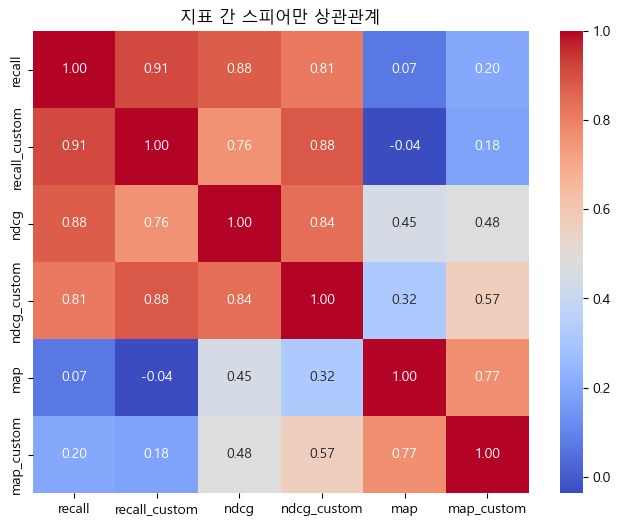

                 recall  recall_custom      ndcg  ndcg_custom       map  \
recall         1.000000       0.912536  0.876089     0.813743  0.070260   
recall_custom  0.912536       1.000000  0.759238     0.884458 -0.037433   
ndcg           0.876089       0.759238  1.000000     0.839753  0.452064   
ndcg_custom    0.813743       0.884458  0.839753     1.000000  0.315502   
map            0.070260      -0.037433  0.452064     0.315502  1.000000   
map_custom     0.201619       0.184523  0.478372     0.570256  0.767443   

               map_custom  
recall           0.201619  
recall_custom    0.184523  
ndcg             0.478372  
ndcg_custom      0.570256  
map              0.767443  
map_custom       1.000000  


In [67]:
metrics_cols = ['recall', 'recall_custom', 'ndcg', 'ndcg_custom', 'map', 'map_custom']
corr_matrix = filtered_result[metrics_cols].corr(method='spearman')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("지표 간 스피어만 상관관계")
plt.show()

print(corr_matrix)

In [ ]:
k = 50  # top-k

topk_base = optimization_result.nsmallest(k, 'overall_rank').index
topk_custom = optimization_result.nsmallest(k, 'overall_custom_rank').index

topk_overlap = len(set(topk_base) & set(topk_custom))
print(f"Top-{k} 겹치는 항목 수: {topk_overlap}개 / {k}개 중 ({topk_overlap/k:.2%})")

optimization_result['rank_diff'] = (optimization_result['overall_rank'] - optimization_result['overall_custom_rank']).abs()
top_rank_changes = optimization_result.nlargest(k, 'rank_diff')

param_cols = ['k', 'alpha', 'dense_type', 'morphological_analyzer', 'fetch_k', 'lambda_mult', 'score_threshold']
print(top_rank_changes[['overall_rank', 'overall_custom_rank', 'rank_diff'] + param_cols])

Top-50 겹치는 항목 수: 7개 / 50개 중 (14.00%)
     overall_rank  overall_custom_rank  rank_diff   k  alpha dense_type  \
434         343.0                 73.0      270.0  15     40  threshold   
105         142.0                363.0      221.0   5     40        mrr   
278         371.0                152.0      219.0  10     40  threshold   
108         146.0                361.0      215.0   5     40        mrr   
147         207.0                408.0      201.0   5     60        mrr   
102         139.0                333.0      194.0   5     40        mrr   
106         144.0                336.0      192.0   5     40        mrr   
473         462.0                270.0      192.0  15     60  threshold   
103         131.0                320.0      189.0   5     40        mrr   
107         147.0                330.0      183.0   5     40        mrr   
104         138.0                311.0      173.0   5     40        mrr   
395         189.0                 19.0      170.0  15     20  t